# Analysis of Sleep in Mammals Dataset

The "Sleep in Mammals" dataset includes information on 39 species of mammals distributed across 13 different orders. It was used to analyze the relationship between various factors and the sleeping patterns of mammals. The dataset provides insights into the differences in sleep behavior among these species. Here are the key details:

**Variables in the Dataset:**
- **species:** The species of mammals.
- **body_wt:** Total body weight of the mammal in kilograms (kg).
- **brain_wt:** Brain weight of the mammal in kilograms (kg).
- **non_dreaming:** Number of hours of non-dreaming sleep.
- **dreaming:** Number of hours of dreaming sleep.
- **total_sleep:** Total number of hours of sleep.
- **life_span:** The average lifespan of the mammal in years.
- **gestation:** The duration of gestation or pregnancy in days.
- **predation:** An index indicating how likely the mammal is to be preyed upon, ranging from 1 (least likely) to 5 (most likely).
- **exposure:** An index indicating how exposed the mammal is during sleep, with values from 1 (least exposed) to 5 (most exposed).
- **danger:** An index reflecting the level of danger the mammal faces from other animals. This index is based on predation and exposure, with values from 1 (least danger) to 5 (most danger).

**Data Source:**
- The original source of the dataset is [here](http://www.statsci.org/data/general/sleep.txt).

**References:**
- The dataset was used in a study titled "Sleep in mammals: ecological and constitutional correlates" by T. Allison and D. Cicchetti, published in "Arch. Hydrobiol," volume 75, page 442, in 1975.

This dataset serves as a valuable resource for researchers studying sleep patterns and the ecological and constitutional factors that influence them in mammals.

In [26]:
# IMPORT & READ
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv("mammals.csv", index_col='species')

target = "total_sleep"

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, Africanelephant to Yellow-belliedmarmot
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   body_wt       62 non-null     float64
 1   brain_wt      62 non-null     float64
 2   non_dreaming  48 non-null     float64
 3   dreaming      50 non-null     float64
 4   total_sleep   58 non-null     float64
 5   life_span     58 non-null     float64
 6   gestation     58 non-null     float64
 7   predation     62 non-null     int64  
 8   exposure      62 non-null     int64  
 9   danger        62 non-null     int64  
dtypes: float64(7), int64(3)
memory usage: 5.3+ KB


In [28]:
df.sample(15)

,body_wt,brain_wt,non_dreaming,dreaming,total_sleep,life_span,gestation,predation,exposure,danger
species,,,,,,,,,,
Okapi,250.000,490.0,NaN,1.0,NaN,23.6,440.0,5,5,5
Mountainbeaver,1.350,8.1,8.4,2.8,11.2,NaN,45.0,3,1,3
Roedeer,14.830,98.2,NaN,NaN,2.6,17.0,150.0,5,5,5
Rabbit,2.500,12.1,7.5,0.9,8.4,18.0,31.0,5,5,5
EasternAmericanmole,0.075,1.2,6.3,2.1,8.4,3.5,42.0,1,1,1
Starnosedmole,0.060,1.0,8.1,2.2,10.3,3.5,NaN,3,1,2
Chimpanzee,52.160,440.0,8.3,1.4,9.7,50.0,230.0,1,1,1
Deserthedgehog,0.550,2.4,7.6,2.7,10.3,NaN,NaN,2,1,2
Africangiantpouchedrat,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3,1,3


# FUNCTIONS

In [29]:
# IMPUTE_MISSING_VALUES

from sklearn.impute import SimpleImputer

def impute_missing_values(df):
    # Identify columns with missing values
    missing_columns = df.columns[df.isna().any()]

    # Select numeric and categorical columns
    missing_df = df[missing_columns]
    numeric_columns = missing_df.select_dtypes(include='number').columns
    categorical_columns = missing_df.select_dtypes(include='object').columns

    # Fill missing values with mode in categorical columns
    df_cleaned = df.copy()
    for column in categorical_columns:
        if df_cleaned[column].mode().empty:
            continue
        df_cleaned[column].fillna(df_cleaned[column].mode().iloc[0], inplace=True)

    # Fill missing values with mean in numeric columns
    imp = SimpleImputer(strategy='mean')
    df_cleaned[numeric_columns] = imp.fit_transform(df_cleaned[numeric_columns])

    return df_cleaned


In [30]:
# MUTUAL_INFORMATION

from sklearn.feature_selection import mutual_info_regression
def m_info_r(X, y):
   
    
    mi_scores = mutual_info_regression(X, y, discrete_features="auto", random_state=0) # Calculate mi scores
    
    # Create a Series with feature names as index and sorted mutual information scores
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

 
def plot_mi_scores(mi_scores, top_n=20):
    plt.figure(dpi=100, figsize=(10, 6))
    sns.barplot(x=mi_scores.head(top_n), y=mi_scores.head(top_n).index, palette='viridis')
    plt.title("Mutual Information Scores")
    plt.show()

In [31]:
# SEABORN_VISUALIZATION

def visualize_numerical_columns(df, num_cols_per_row=3):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate the number of rows needed for subplots
    num_rows = (len(numerical_cols) - 1) // num_cols_per_row + 1

    # Set plot style and palette
    sns.set_style("dark")
    sns.set_palette("dark")

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(12, 4 * num_rows))
    fig.tight_layout(pad=4.0)

    # Plot histograms for numerical columns
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(df[col], ax=ax, edgecolor='white', color='#a2d2ff', bins=20)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Count')

    # Remove empty subplots
    if len(numerical_cols) % num_cols_per_row != 0:
        empty_subplots = num_rows * num_cols_per_row - len(numerical_cols)
        for ax in axes.flatten()[-empty_subplots:]:
            ax.remove()

    plt.show()

def seaborn_correlation_matrix(df):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(6, 4))

    # Generate a custom colormap
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, annot_kws={"fontsize": 8})

    # Show the plot
    plt.show()

def visualize_binary_relationships(df, target_column):
    g = sns.pairplot(data=df, hue=target_column, palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(fill=True), plot_kws=dict(s=10))
    g.set(xticklabels=[])




In [32]:
# PLOTLY_VISUALIZATION

import plotly.graph_objects as go
import plotly.express as px


def explore_dependent_variable(target):
   

    # Create a histogram of the target column
    hist_data = go.Histogram(x=target, nbinsx=100, name="Histogram", opacity=0.75, histnorm='probability density', marker=dict(color='blueviolet'))


    # Combine the histogram and the overlay
    fig = go.Figure(data=[hist_data])

    # Set the layout for the plot
    fig.update_layout(
        title="Dependent Variable Distribution",
        xaxis_title="Dependent Variable",
        yaxis_title="Density",
        legend_title_text="Fitted Normal Distribution",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Create a Q-Q plot
    qq_data = stats.probplot(target, dist="norm")
    qq_fig = px.scatter(x=qq_data[0][0], y=qq_data[0][1], labels={'x': 'Theoretical Quantiles', 'y': 'Ordered Values'}, color_discrete_sequence=["blueviolet"])
    qq_fig.update_layout(
        title="Q-Q plot",
        plot_bgcolor='rgba(32, 32, 32, 1)',
        paper_bgcolor='rgba(32, 32, 32, 1)',
        font=dict(color='white')
    )

    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(qq_data[0][0], qq_data[0][1])
    line_x = np.array(qq_data[0][0])
    line_y = intercept + slope * line_x

    # Add the line of best fit to the Q-Q plot
    line_data = go.Scatter(x=line_x, y=line_y, mode="lines", name="Normal Line", line=dict(color="white"))

    # Update the Q-Q plot with the normal line
    qq_fig.add_trace(line_data)

    # Show the plots
    fig.show()
    qq_fig.show()


def explore_categorical_relationships(df, group_column, target_column):
    grouped_counts = df[group_column].value_counts()
    grouped_averages = df.groupby(group_column)[target_column].mean()

    formatted_averages = ['' + f'{value:,.2f}' for value in grouped_averages.values]

    fig1 = go.Figure(data=[go.Bar(
        x=grouped_counts.index,
        y=grouped_counts.values,
        marker_color='rgb(76, 175, 80)',
        text=grouped_counts.values,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig1.update_layout(
        title=f'Distribution of {group_column}',
        xaxis_title=group_column,
        yaxis_title='Count',
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig2 = go.Figure(data=[go.Bar(
        x=grouped_averages.index,
        y=grouped_averages.values,
        marker_color='rgb(156, 39, 176)',
        text=formatted_averages,
        textposition='outside',
        width=0.4,
        marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
    )])
    fig2.update_layout(
        title=f'Average {target_column} by {group_column}',
        xaxis_title=group_column,
        yaxis_title=target_column,
        plot_bgcolor='rgba(34, 34, 34, 1)',
        paper_bgcolor='rgba(34, 34, 34, 1)',
        font=dict(color='white'),
        height=500  # Adjust the height value as desired
    )

    fig1.show()
    fig2.show()


def explore_numerical_correlation(df, feature_column, target_column):
    # Calculate correlation between feature and target
    feature_target_corr = df[feature_column].corr(df[target_column])
    print(f'Correlation between {feature_column} and {target_column}: {feature_target_corr}')

    # Create a scatter plot to visualize the relationship between feature and target
    fig = px.scatter(df, x=feature_column, y=target_column, title=f'{feature_column} vs {target_column}', color=feature_column, color_continuous_scale=px.colors.sequential.Purp)
    fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
    fig.show()



# DATA EXPLORATION


In [33]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(62, 10)

Duplicate Values:
( 0 )

Data Types:
float64    7
int64      3
Name: count, dtype: int64

Missing Data:
              Total    Percent
non_dreaming     14  22.580645
dreaming         12  19.354839
total_sleep       4   6.451613
life_span         4   6.451613
gestation         4   6.451613


In [34]:
# Calculate mutual information scores

# Create a new DataFrame without null values
df_m = impute_missing_values(df.copy(deep=True))


X_m = df_m

y_m = X_m.pop('total_sleep')


In [35]:
X_m.head()

y_m.head()

species
Africanelephant            3.3
Africangiantpouchedrat     8.3
ArcticFox                 12.5
Arcticgroundsquirrel      16.5
Asianelephant              3.9
Name: total_sleep, dtype: float64

C:\Users\lacom\AppData\Local\Temp\ipykernel_2340\1266330775.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




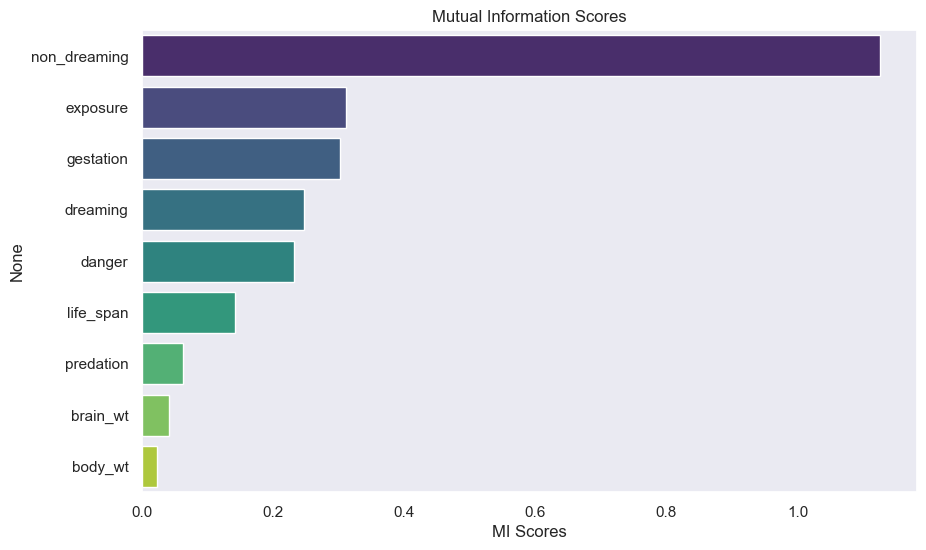

non_dreaming    1.124903
exposure        0.311833
gestation       0.303173
dreaming        0.247215
danger          0.233122
life_span       0.142288
predation       0.062539
brain_wt        0.042063
body_wt         0.023635
Name: MI Scores, dtype: float64


In [36]:
# MUTUAL INFORMATION SCORES



# Calculate mutual information (_r or _c)
m_info_scores = m_info_r(X_m, y_m)

# Plot the mutual information scores
plot_mi_scores(m_info_scores, top_n=20)

# Display the top 10 mutual information scores
print(m_info_scores.head(10))

ANALYSIS

In [37]:
# Predation

explore_categorical_relationships(df, 'predation', target)



**The "risk of predation" refers to the likelihood or risk of an animal being hunted or preyed upon by other animals.** It's a measure of how vulnerable a species is to predation or being the target of predators in its natural environment.

**Species with a high risk of predation are more likely to be hunted by other animals,** while those with a low risk of predation are less likely to be targeted by predators. This concept is important in ecology and animal behavior studies as it influences various aspects of an animal's life, such as its behavior, habitat selection, and survival strategies.

NUMERICAL ANALYSIS


Highest Correlation Values:


non_dreaming  total_sleep    0.962715
brain_wt      body_wt        0.934164
danger        predation      0.916042
              exposure       0.787203
brain_wt      gestation      0.747242
dreaming      total_sleep    0.727087
body_wt       gestation      0.651102
exposure      gestation      0.638279
dtype: float64


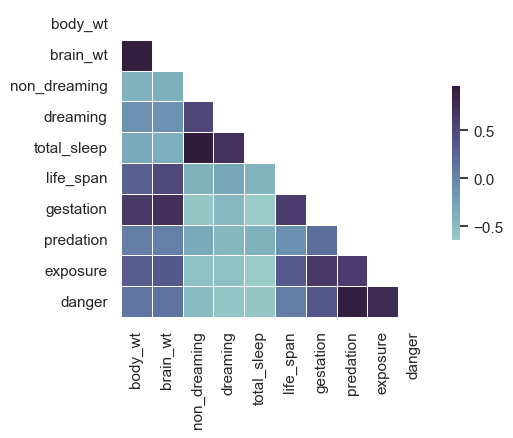

In [38]:
# CORRELATION

correlation_matrix = df.corr(numeric_only=True)

# Get the highest correlation values (excluding self-correlations)
highest_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
highest_corr = highest_corr[(highest_corr != 1.0) & (highest_corr > 0)]

# Display the highest correlation values
print("\nHighest Correlation Values:")
print(highest_corr[:8])



seaborn_correlation_matrix(df)

These correlation values indicate the strength and direction of relationships between pairs of variables in the dataset.

1. **Non-Dreaming Sleep and Total Sleep (0.9627):** This strong positive correlation suggests that as the duration of non-dreaming sleep increases, the total sleep duration also tends to increase. These two sleep patterns are closely related.

2. **Brain Weight and Body Weight (0.9342):** A high positive correlation indicates that larger animals with higher body weights tend to have larger brains. There is a strong association between body size and brain size.

3. **Danger and Predation (0.9160):** The positive correlation implies that species facing higher perceived danger levels are more likely to experience increased predation risk. These two variables are positively related.

4. **Danger and Exposure (0.7872):** There is a positive correlation between danger and exposure, suggesting that animals in more dangerous environments tend to have higher levels of exposure to these risks.

5. **Brain Weight and Gestation (0.7472):** The positive correlation indicates that species with larger brains tend to have longer gestation periods. Brain size appears to be related to the duration of gestation.

6. **Dreaming Sleep and Total Sleep (0.7271):** The positive correlation suggests that as total sleep duration increases, the duration of dreaming sleep also tends to increase. These two types of sleep are positively associated.

7. **Body Weight and Gestation (0.6511):** This correlation indicates that larger animals with higher body weights tend to have longer gestation periods. There is a moderate positive relationship between body weight and gestation duration.

8. **Exposure and Gestation (0.6383):** The positive correlation implies that species in environments with higher exposure levels tend to have longer gestation periods. Exposure and gestation are positively related.



**Based on the high positive correlation between "Danger" and "Predation"** (correlation value of 0.9160), it appears that these two variables are strongly related and provide similar information. In some cases, it might be reasonable to consider removing one of them to avoid redundancy in your analysis, as they are measuring similar aspects of risk or threat.


1. High correlation values between 'total_amount' and 'fare_amount' (0.987303) and 'total_amount' and 'tip_amount' (0.770913) suggest strong linear relationships.
2. Multicollinearity, caused by highly correlated variables, can negatively affect the multiple linear regression model's stability and coefficient estimates.
3. To address multicollinearity, consider dropping one of the highly correlated columns, possibly 'total_amount,' while considering domain knowledge and analysis objectives.
4. Assess the model's performance after any changes to ensure its predictive power and interpretability remain intact.

In [39]:
# STATS
summary = df.describe().T.sort_values(by='std', ascending=False).head(10)
summary

,count,mean,std,min,25%,50%,75%,max
brain_wt,62.0,283.134194,930.278942,0.140,4.250,17.2500,166.0000,5712.0
body_wt,62.0,198.789984,899.158011,0.005,0.600,3.3425,48.2025,6654.0
gestation,58.0,142.353448,146.805039,12.000,35.750,79.0000,207.5000,645.0
life_span,58.0,19.877586,18.206255,2.000,6.625,15.1000,27.7500,100.0
total_sleep,58.0,10.532759,4.606760,2.600,8.050,10.4500,13.2000,19.9
non_dreaming,48.0,8.672917,3.666452,2.100,6.250,8.3500,11.0000,17.9
exposure,62.0,2.419355,1.604792,1.000,1.000,2.0000,4.0000,5.0
predation,62.0,2.870968,1.476414,1.000,2.000,3.0000,4.0000,5.0
dreaming,50.0,1.972000,1.442651,0.000,0.900,1.8000,2.5500,6.6
danger,62.0,2.612903,1.441252,1.000,1.000,2.0000,4.0000,5.0


The data shows a remarkable diversity in brain weights, ranging from as low as 0.140 grams to an astonishing 5712 grams, with an average of 283.13 grams. Similarly, body weights vary widely, from 0.005 grams to 6654 grams, with a mean of 198.79 grams.

**Gestation periods also vary significantly,** with the shortest being 12 days and the longest reaching 645 days. The average gestation period is approximately 142.35 days, illustrating a wide range of reproductive strategies among the studied animals.

**Life spans vary greatly, from a minimum of 2 years to a maximum of 100 years,** with an average life span of around 19.88 years. This implies substantial differences in longevity among species.

**Sleep patterns, exposure to predation, and perceived danger levels exhibit diversity,** highlighting the complex interactions and adaptations within the animal kingdom. Further research is essential to understand the underlying factors and relationships between these variables.

TARGET ANALYSIS

Skewness: 0.207708
Kurtosis: -0.329429


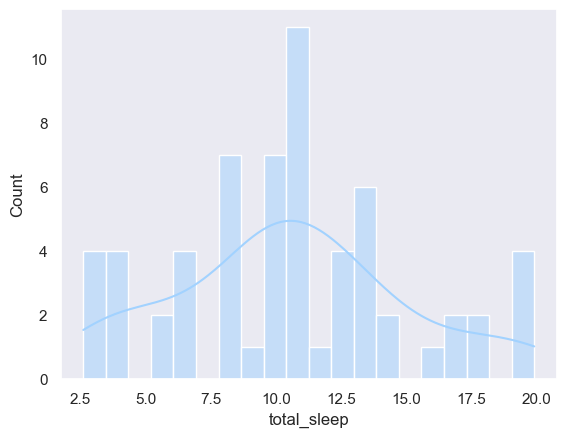

In [40]:
# TARGET DISTRIBUTION

sns.set_style("dark")
sns.set_palette("dark")

# Plot histogram using histplot
sns.histplot(y_m, kde=True, edgecolor='white', linewidth=1, color='#a2d2ff', bins=20)


#skewness and kurtosis
print("Skewness: %f" % y_m.skew())
print("Kurtosis: %f" % y_m.kurt())

Conlusions:

1. **Skewness (0.2077):** The slightly positive skewness of 0.2077 indicates that the distribution of "total_sleep" is slightly right-skewed. Most of the values are concentrated on the lower end of the sleep duration, with some higher values extending the right tail. This suggests that there are relatively fewer extreme values on the high end of total sleep duration.

2. **Kurtosis (-0.3294):** The negative kurtosis of -0.3294 means that the distribution of "total_sleep" has lighter tails and is flatter compared to a normal distribution (kurtosis of 0). It implies that there are fewer extreme values (outliers) in the distribution, and the data points are more spread out.

For your "total_sleep" variable, these characteristics indicate that most animals have relatively shorter total sleep durations, with fewer having longer sleep durations.

In [41]:
# TARGET CORRELATIONS

correlation_matrix = df.corr(numeric_only=True)

# Filter correlations for 'Price' column only
price_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False)

# Display the correlations with 'Price'
print("\nCorrelations with Target:")
print(price_correlations[:25])



Correlations with Target:
non_dreaming    0.962715
dreaming        0.727087
body_wt        -0.307186
brain_wt       -0.358102
predation      -0.395835
life_span      -0.410202
danger         -0.587742
gestation      -0.631326
exposure       -0.642285
Name: total_sleep, dtype: float64


Relationships between total sleep duration and these factors:

1. **Non-Dreaming Sleep (0.9627):** These two sleep patterns are closely related, suggesting that animals with longer total sleep tend to have more extended periods of non-dreaming sleep.

2. **Dreaming Sleep (0.7271):** As total sleep duration increases, the duration of dreaming sleep also tends to increase. This implies that animals with longer total sleep tend to experience more extended periods of dreaming sleep.

3. **Body Weight (-0.3072):** This indicates that, on average, smaller animals tend to have longer total sleep durations, while larger animals have shorter total sleep durations.

4. **Brain Weight (-0.3581):** A moderate negative correlation is also observed between "total_sleep" and "brain_wt" (-0.3581). This suggests that animals with larger brains tend to have shorter total sleep durations, while those with smaller brains have longer total sleep durations.

5. **Predation (-0.3958):** This implies that species facing higher levels of predation risk tend to have shorter total sleep durations, while those with lower predation risk have longer total sleep durations.

In summary, "total_sleep" is strongly positively correlated with both non-dreaming sleep and dreaming sleep, indicating a close relationship between these sleep patterns. Additionally, it has moderate negative correlations with body weight, brain weight, and predation, suggesting that these factors are associated with variations in total sleep duration among different species. 

In [42]:
# VISUALIZE SIMPLE REGRESSION BETWEEN GESTATION AND TOTAL SLEEP

explore_numerical_correlation(df, 'gestation', target)

Correlation between gestation and total_sleep: -0.631326200799825


**Conclusions:**

1. A moderately strong negative correlation (-0.6145) exists between "gestation" and "total_sleep."

2. This means that as the gestation duration of mammals increases, their total sleep duration tends to decrease.

3. Conversely, species with shorter gestation periods tend to have longer total sleep durations.

4. This correlation suggests a potential biological or ecological relationship between reproductive processes and sleep patterns in mammals, meriting further investigation.

OUTLIER ANALYSIS

Outliers are a natural reflection of the complexity and richness of the mammalian kingdom, warranting appropriate data analysis approaches in research.

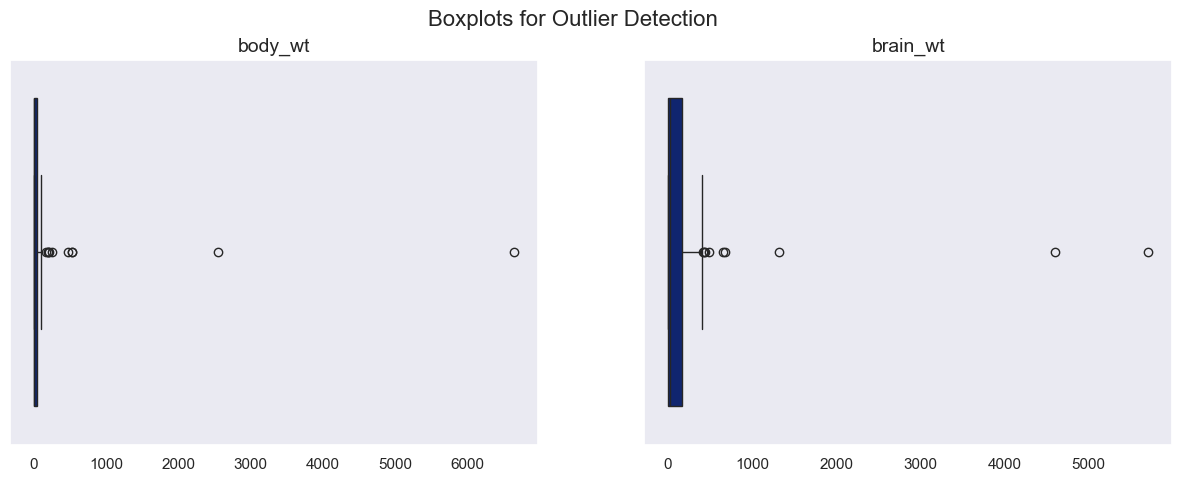

In [43]:
# VISUALIZE OUTLIERS

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16)

# Plot 1: trip_distance
sns.boxplot(ax=axes[0], x=df['body_wt'])
axes[0].set_title('body_wt', fontsize=14)
axes[0].set_xlabel('')

# Plot 2: fare_amount
sns.boxplot(ax=axes[1], x=df['brain_wt'])
axes[1].set_title('brain_wt', fontsize=14)
axes[1].set_xlabel('')


plt.show()


# PREPROCESSING

MISSING VALUES

In [44]:
print('Missing values:',df.isna().sum().max())

Missing values: 14


In [45]:
df.dropna(inplace=True)

In [46]:
print('Missing values after drop:',df.isna().sum().max())

Missing values after drop: 0


# FEATURES SELECTION


**Features Correlated with Each Other:** We consider keeping one and dropping the other, as they provide similar information.

   - `body_wt` and `brain_wt` (0.955) are highly correlated. 
   - `danger` and `predation` (0.927) are highly correlated.
   - `danger` and `exposure` (0.789) are also highly correlated. We should choose one of them based on our research goals.
   - `gestation` and `brain_wt` (0.733) are moderately correlated. We may keep both or choose one.



In [47]:
# Define a list of columns to drop
columns_to_drop = ['brain_wt', 'exposure','predation','non_dreaming']

# Drop the selected columns from the DataFrame
df1 = df.drop(columns=columns_to_drop)


We are dropping these columns because they are highly correlated with other features in the dataset, which can lead to redundancy and multicollinearity in statistical analyses.

1. **brain_wt**: This column is highly correlated with "body_wt" (body weight), and they both provide similar information about the size of the mammals. By keeping both, we introduce multicollinearity, which can affect the stability of statistical models. Therefore, we choose to keep one that is more relevant to our analysis.

2. **exposure**: It is highly correlated with "danger" and, to some extent, with "predation." These three columns provide related information about the danger and risk faced by mammals, and retaining all of them can introduce redundancy. We decide to choose one based on our research objectives.

3. **predation**: This column is also highly correlated with "danger" and "exposure." Since it provides similar information about the risk of predation, we consider retaining one of them to simplify the dataset.

In summary, by dropping these columns, we aim to reduce redundancy and multicollinearity, which can lead to more robust and interpretable analyses. The specific columns to drop may depend on the research goals and the context of the analysis.

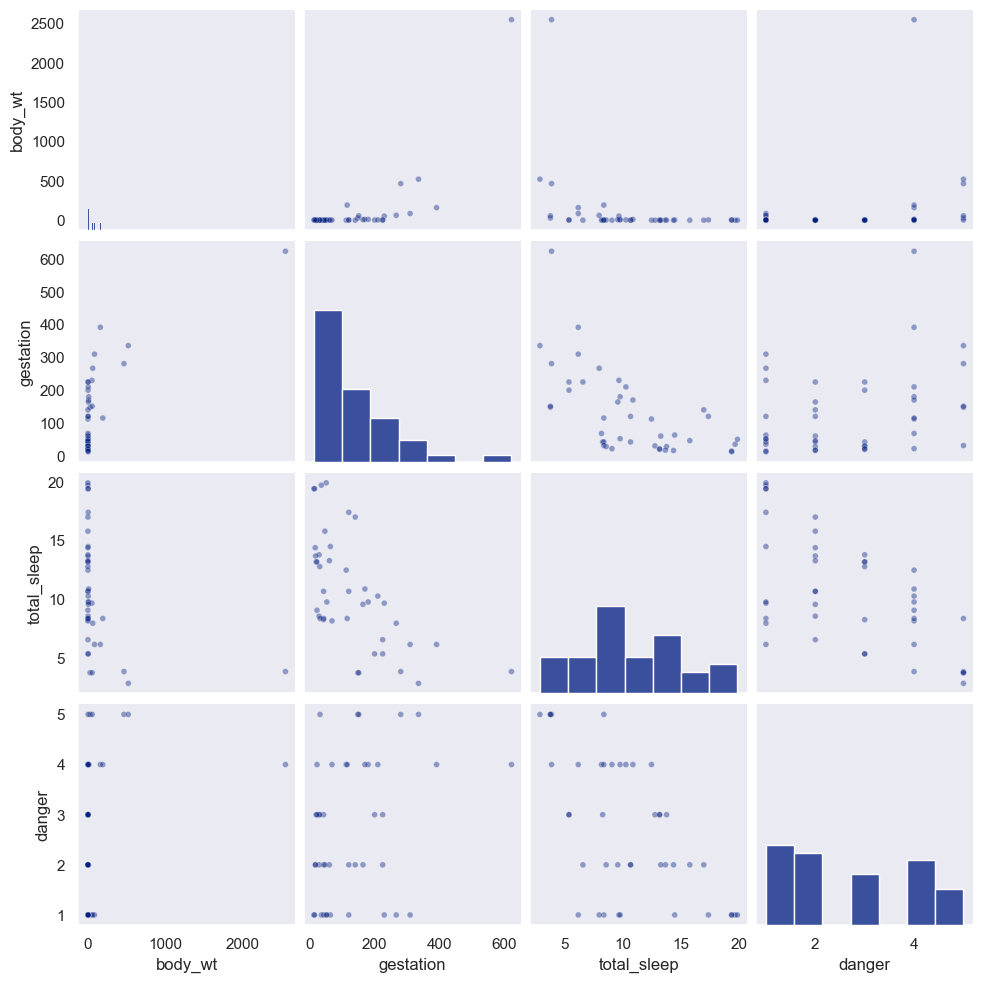

In [48]:
sns.pairplot(df1[['body_wt', 'gestation', 'total_sleep','danger']],
             plot_kws={'alpha': 0.4, 'size': 5})


# CONSTRUCT AND EXECUTE THE MODEL

I have chosen XGBoost over multiple regression because XGBoost can effectively capture complex and non-linear relationships in the data, leading to more accurate fare predictions. Its ensemble nature allows it to handle a wide range of features and deliver better performance compared to traditional regression methods. With its robustness and versatility, XGBoost proves to be a powerful and reliable choice for taxi fare estimation, making it the preferred algorithm for this task.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [50]:
# Define your target variable (Y) and features (X)
y = df1['total_sleep']  # Replace 'total_sleep' with your actual target variable
X = df1.drop(columns=['total_sleep'])  # Remove the target variable from the features


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [51]:
# Create and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 15.751798624227145
R-squared: 0.39265620933063006


These results show that the XGBoost regression model is performing quite well in estimating taxi fares based on the selected features. The MSE is relatively low, indicating good predictive accuracy, and the R-squared value is high, indicating a good fit to the data. This suggests that the model is making accurate predictions and capturing the underlying patterns in the fare data.

### **Hyperparameter tunning**

In [53]:

from sklearn.model_selection import GridSearchCV


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost regressor model
xgb_model = xgb.XGBRegressor()

# Define the hyperparameters you want to tune and their possible values
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 19.96767950713938
R-squared: 0.2301040375106913




In this code, we use the GridSearchCV function from scikit-learn to perform a grid search with cross-validation to find the best hyperparameters for the XGBoost regressor. The param_grid variable contains the hyperparameters we want to tune, and their possible values. The GridSearchCV will try all possible combinations of hyperparameters and select the best ones based on cross-validation performance.

After finding the best hyperparameters, we train the final XGBoost regressor model using these optimal settings and make predictions on the test set. Finally, we evaluate the model's performance using mean squared error and R-squared metrics.






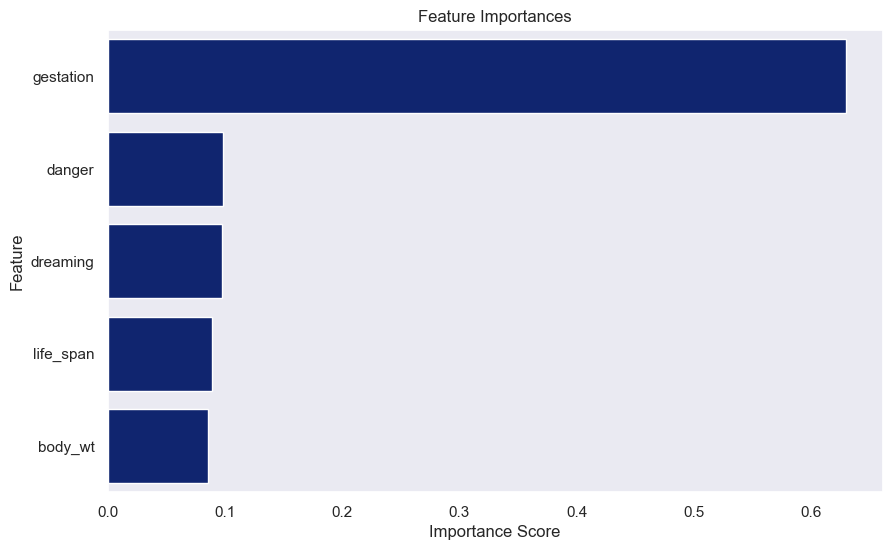

In [54]:

# Access the feature importances
feature_importances = final_model.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


In [55]:
print(importance_df)


     Feature  Importance
3  gestation    0.629438
4     danger    0.098440
1   dreaming    0.097841
2  life_span    0.088971
0    body_wt    0.085310


### **Conclusion and Key Insights:**

The feature importance analysis provides crucial insights into the factors that significantly contribute to predicting sleep patterns in mammals.

1. **Gestation Dominance (Feature Importance: 0.629438):**
   - **Insight:** Gestation period overwhelmingly stands out as the primary influencer of sleep patterns.
   
   - **Significance:** Mammals with longer gestation periods exhibit distinct sleep characteristics, suggesting a profound connection between reproductive strategies and sleep regulation.
   

2. **Environmental Impact (Feature Importance: 0.098440):**
   - **Insight:** The level of danger in the environment significantly affects sleep behavior.

   - **Significance:** Sleep adaptations in response to environmental threats highlight the intricate interplay between survival instincts and sleep evolution.


3. **Dreaming Sleep Significance (Feature Importance: 0.097841):**
   - **Insight:** Dreaming sleep emerges as a noteworthy predictor of overall sleep patterns.

   - **Significance:** The role of dreaming sleep hints at the potential involvement of cognitive and emotional processes in shaping sleep architecture, opening avenues for exploring the higher functions of sleep.


4. **Life Span's Impact (Feature Importance: 0.088971):**
   - **Insight:** Life span contributes significantly to predicting sleep patterns.

   - **Significance:** Longer life spans correlate with specific sleep adaptations, underscoring the potential influence of aging processes on sleep regulation.


5. **Weight's Modest Role (Feature Importance: 0.085310):**
   - **Insight:** Body weight plays a notable but comparatively lesser role in predicting sleep patterns.
   
   - **Significance:** While weight is a factor, the study emphasizes that other elements such as gestation, danger, and dreaming sleep exert more substantial influences on sleep, sparking curiosity for further investigation.

